In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
mf_lr_df = pd.read_csv('../data/AGP-COVID19/log-ratio-hs-hk-genes.csv', index_col=0)
mf_lr_df.head(5)


,hkgenes,hsgenes,lr,lr_ps,acid_reflux,acne_medication,acne_medication_otc,add_adhd,age_cat,age_corrected,...,weight_cat,weight_change,weight_kg,weight_units,whole_eggs,whole_grain_frequency,age_years_decade,covid_chronic_conditions_total,covid_chronic_conditions_all,covd_relabel
10317.X00179385,870,27,-3.472656,-3.437437,I do not have this condition,No,No,I do not have this condition,60s,NaN,...,NaN,Increased more than 10 pounds,100.69762589471202,kilograms,Occasionally (1-2 times/week),Rarely (less than once/week),60-70,0,No,No
10317.X00179178,4519,25,-5.197170,-5.158171,I do not have this condition,No,No,I do not have this condition,30s,NaN,...,NaN,Increased more than 10 pounds,78.01798042293004,kilograms,Occasionally (1-2 times/week),Rarely (less than once/week),30-40,0,No,No
10317.X00179613,1936,4,-6.182085,-5.959458,I do not have this condition,No,No,I do not have this condition,40s,NaN,...,NaN,Remained stable,61.235042773811365,kilograms,Regularly (3-5 times/week),Rarely (less than once/week),40-50,1,Yes,No
10317.X00185577,1976,16,-4.816241,-4.756122,"Diagnosed by a medical professional (doctor, p...",No,No,I do not have this condition,20s,NaN,...,NaN,Remained stable,62.595821502118284,kilograms,Occasionally (1-2 times/week),Rarely (less than once/week),20-30,1,Yes,No
10317.X00179722,8709,16,-6.299524,-6.239014,I do not have this condition,No,No,I do not have this condition,child,NaN,...,NaN,Remained stable,22.67964547178199,kilograms,Never,Daily,5-10,4,Yes,No


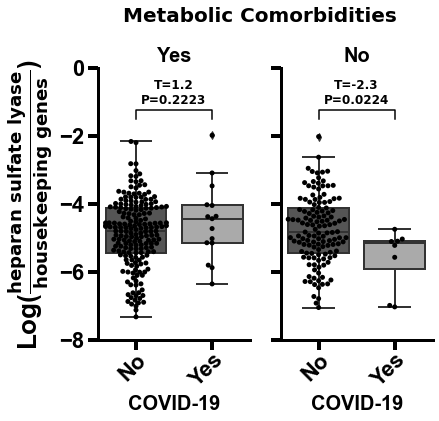

In [3]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'Log($\\frac{\mathrm{heparan\,\,sulfate\,\,lyase}}{\mathrm{housekeeping\,\,genes}}$)'

fig, axn = plt.subplots(1, 2, figsize=(6,5), sharey=True)

from collections import Counter


mf_lr_df_subset = mf_lr_df.copy()

for title_, ax in zip(['Yes', 'No'], axn):

    y_ = 'lr'
    order_map = {'No':0, 'Yes':1}
    order_ = ['No', 'Yes']
    lrdf_plot = mf_lr_df_subset[mf_lr_df_subset.covid_chronic_conditions_all == title_].dropna(subset=[y_, 'covd_relabel'])

    t_res = {}
    lrs_ds = {ds_:dsdf_.lr.values for ds_, dsdf_ in lrdf_plot.groupby('covd_relabel')}
    comobos = [('Yes', 'No')]
    for c1, c2 in comobos:
        t_stat, p_ = ttest_ind(lrs_ds[c1], lrs_ds[c2])
        t_res[(c1, c2)] =  t_stat, p_
    t_resdf = pd.DataFrame(t_res).T
    order_map_stats = {(order_map[k[0]], order_map[k[1]]):v for k, v in t_res.items()}

    sns.swarmplot(y=y_, x='covd_relabel', 
                  data=lrdf_plot, 
                  color='black',
                  order=order_,
                  s=5,
                  ax=ax)
    sns.boxplot(y=y_, x='covd_relabel', 
                  data=lrdf_plot,
                  palette='gray',
                  order=order_,
                 ax=ax, linewidth=2)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .0))


    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(3)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45,
                       horizontalalignment='right',
                       rotation_mode="anchor")
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_ha("right")
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    ax.set_ylim(-8, 0)

    if title_ == 'Yes':
        ax.set_ylabel(label_,
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')
    else:
        ax.set_ylabel('',
                      fontsize=26,
                      family = 'arial',
                      weight='bold',
                      color='black')        
    ax.set_title(title_,
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')
    ax.set_xlabel('COVID-19',
                  fontsize=20,
                  family = 'arial',
                  weight='bold',
                  color='black')


    for i_v, ((x1, x2), (stat_, p_)) in enumerate(order_map_stats.items()):
        y, h, col = (i_v * 1.2) - 1.5, 0.25, 'k'
        ax.plot([x1, x1, x2, x2],
                 [y, y+h, y+h, y],
                 lw=1.5, c=col)
        if 'e' in str(p_):
            p_ = str(p_)
            p_ = p_[:3] + p_[p_.index('e'):]
            p_ = "T=%.1f\nP=%s" % (stat_, p_)
        else:
            p_ = "T=%.1f\nP=%.4f" % (stat_, p_)
        ax.text((x1+x2) * .5, y+h+.1,
                 p_, ha='center',fontsize=12,
                 va='bottom', color=col)

plt.suptitle('Metabolic Comorbidities', fontsize=20, color='black', weight='bold', y=1.05)
        
plt.savefig('../results/figures/Fig2F.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

rv = 'lr'
use_columns = ['covid_chronic_conditions_all','covd_relabel','sex','age_years']
meta_stat = mf_lr_df_subset.dropna(subset=[y_] + use_columns)

mod = smf.ols(formula = rv + ' ~ ' + ' + '.join(use_columns) + ' + covid_chronic_conditions_all*covd_relabel',
              data = meta_stat)
res = mod.fit()
resdf = res.summary2().tables[1].round(3)
resdf


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-4.996,0.176,-28.407,0.000,-5.342,-4.650
covid_chronic_conditions_all[T.Yes],-0.114,0.114,-0.999,0.318,-0.339,0.111
covd_relabel[T.Yes],-0.849,0.363,-2.339,0.020,-1.564,-0.135
sex[T.male],-0.112,0.111,-1.012,0.312,-0.331,0.106
sex[T.other],-0.071,1.006,-0.070,0.944,-2.049,1.908
covid_chronic_conditions_all[T.Yes]:covd_relabel[T.Yes],1.198,0.451,2.654,0.008,0.310,2.086
age_years,0.006,0.004,1.807,0.072,-0.001,0.013
